<a href="https://colab.research.google.com/github/adit333/handson_machine_learning/blob/main/support_vector_machines_ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Support Vector Machines***

In [ ]:
import sklearn

assert sklearn.__version__ >= "1.0.1"

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#**Linear SVM Classification**

The following Scikit-Learn code loads the iris dataset, scales the features, and then
trains a linear SVM model (using the LinearSVC class with C=1 and the hinge loss
function, described shortly) to detect Iris virginica flowers:

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)  # Iris virginica

svm_clf = make_pipeline(StandardScaler(),
                        LinearSVC(C=1, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [ ]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

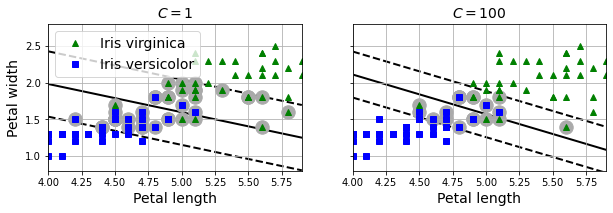

In [ ]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, random_state=42)

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.show()

# **Nonlinear SVM Classification**

Although linear SVM classifiers are efficient and work surprisingly well in many
cases, many datasets are not even close to being linearly separable. One approach to
handling nonlinear datasets is to add more features, such as polynomial features; in some cases this can result in a linearly separable dataset.

In [ ]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, random_state=42)
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

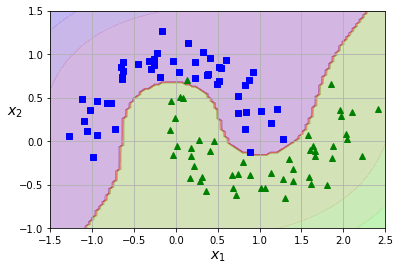

In [ ]:
# extra code â€“ this cell generates and saves Figure 5â€“6

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

## Polynomial Kernel

Adding polynomial features is simple to implement and can work great with all sorts
of Machine Learning algorithms (not just SVMs). That said, at a low polynomial
degree, this method cannot deal with very complex datasets, and with a high polynomial
degree it creates a huge number of features, making the model too slow.


Fortunately, when using SVMs you can apply an almost miraculous mathematical
technique called the kernel trick (explained in a moment). The kernel trick makes it
possible to get the same result as if you had added many polynomial features, even
with very high-degree polynomials, without actually having to add them. So there is
no combinatorial explosion of the number of features because you donâ€™t actually add
any features. This trick is implemented by the SVC class. Letâ€™s test it on the moons
dataset:

In [ ]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

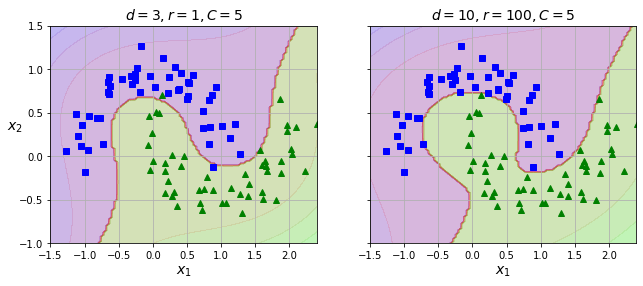

In [ ]:
poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$")
plt.ylabel("")

plt.show()

## Gaussian RBF Kernel

Another technique to tackle nonlinear problems is to add features computed using a
similarity function, which measures how much each instance resembles a particular
landmark

In [ ]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

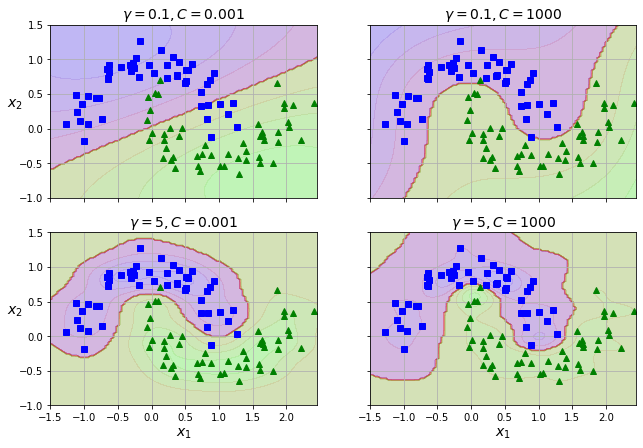

In [ ]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(fr"$\gamma = {gamma}, C = {C}$")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

# **SVM Regression**

In [ ]:
from sklearn.svm import LinearSVR

# extra code â€“ these 3 lines generate a simple linear dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1)   # 50 x 1 column vector
y = 4 + 3 * X[:, 0] + np.random.randn(50) # 1 x 50 row vector

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.5, random_state=42))])

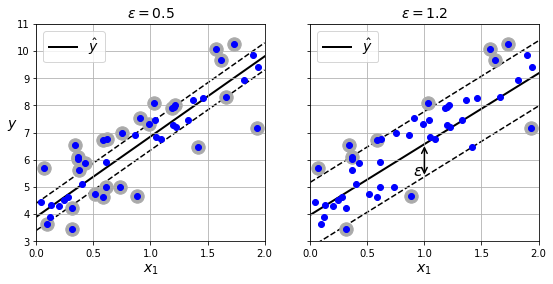

In [ ]:
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(fr"$\epsilon = {svm_reg[-1].epsilon}$")
plt.ylabel(r"$y$", rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(fr"$\epsilon = {svm_reg2[-1].epsilon}$")
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()

plt.show()

# **Applications**

## Linear Data Classifier

_Exercise: Train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model._

Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [ ]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Now let's build and train 3 models:
* Remember that `LinearSVC` uses `loss="squared_hinge"` by default, so if we want all 3 models to produce similar results, we need to set `loss="hinge"`.
* Also, the `SVC` class uses an RBF kernel by default, so we need to set `kernel="linear"` to get similar results as the other two models.
* Lastly, the `SGDClassifier` class does not have a `C` hyperparameter, but it has another regularization hyperparameter called `alpha`, so we can tweak it to get similar results as the other two models.

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 0.05

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42).fit(X_scaled, y)
svc_clf = SVC(kernel="linear", C=C).fit(X_scaled, y)
sgd_clf = SGDClassifier(alpha=alpha, random_state=42).fit(X_scaled, y)

Let's plot the decision boundaries of these three models:

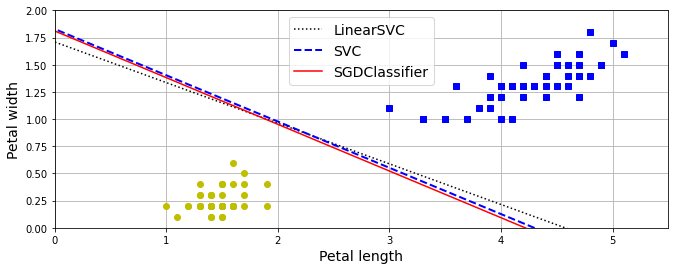

In [ ]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(lin_clf)
svc_line = compute_decision_boundary(svc_clf)
sgd_line = compute_decision_boundary(sgd_clf)

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

Close enough!

## Multiclass Classification

_Exercise: Train an SVM classifier on the Wine dataset, which you can load using `sklearn.datasets.load_wine()`. This dataset contains the chemical analysis of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine's chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 3 classes. What accuracy can you reach?_

In [ ]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [ ]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=42)

In [ ]:
X_train.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
2      13.16        2.36  2.67               18.6      101.0           2.80   
100    12.08        2.08  1.70               17.5       97.0           2.23   
122    12.42        4.43  2.73               26.5      102.0           2.20   
154    12.58        1.29  2.10               20.0      103.0           1.48   
51     13.83        1.65  2.60               17.2       94.0           2.45   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
2          3.24                  0.30             2.81             5.68  1.03   
100        2.17                  0.26             1.40             3.30  1.27   
122        2.13                  0.43             1.71             2.08  0.92   
154        0.58                  0.53             1.40             7.60  0.58   
51         2.99                  0.22             2.29             5.60  1.24   

     od280/od315_of_diluted_wines  proline  
2                            3.17   1185.0  
100                          2.96    710.0  
122                          3.12    365.0  
154                          1.55    640.0  
51                           3.37   1265.0

In [ ]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int64

Let's now scale the data. Data scaling is very important fo SVM's:

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do to handle multiple classes. Easy, right?

In [ ]:
lin_clf = make_pipeline(StandardScaler(),
                        LinearSVC(random_state=42))
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

0.9774928774928775

Let's see if a kernelized SVM will do better. We will use a default `SVC` for now:

In [ ]:
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
cross_val_score(svm_clf, X_train, y_train).mean()

0.9698005698005698

That's not better, but perhaps we need to do a bit of hyperparameter tuning:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distrib = {
    "svc__gamma": reciprocal(0.001, 0.1),
    "svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=9.925589984899778, gamma=0.011986281799901176,
                     random_state=42))])

In [ ]:
rnd_search_cv.best_score_

0.9925925925925926

In [ ]:
rnd_search_cv.best_params_

{'svc__C': 9.925589984899778, 'svc__gamma': 0.011986281799901176}

In [ ]:
rnd_search_cv.score(X_test, y_test)

0.9777777777777777

Cool! ðŸ˜Ž

## SVM Regression

_Exercise: Train and fine-tune an SVM regressor on the California housing dataset. The dataset can be fetched using `sklearn.datasets.fetch_california_housing()`. The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use much less instances (e.g., 2,000), to test many more hyperparameter combinations. What is your best model's RMSE?_

In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Let's scale the data before we forget:

Let's train a simple LinearSVR first:

In [ ]:
lin_svr = make_pipeline(StandardScaler(),
                        LinearSVR(max_iter=5000, random_state=42)
)
lin_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(max_iter=5000, random_state=42))])

Let's see how it performs on the training set:

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
mse

0.9595484665813285

Let's look at the RMSE:

In [ ]:
np.sqrt(mse)

0.979565447829459

In this dataset, the targets represent hundreds of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors close to $98,000! Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [ ]:
from sklearn.svm import SVR

svr = make_pipeline(StandardScaler(), SVR())

param_distrib = {
    "svr__gamma": reciprocal(0.001, 0.1),
    "svr__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svr, param_distrib,
                                   n_iter=100, cv=3, random_state=42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f59b4d70850>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f59b450c110>},
                   random_state=42)

In [ ]:
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=4.63629602379294, gamma=0.08781408196485974))])

In [ ]:
-cross_val_score(rnd_search_cv.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [ ]:
y_test_pred = rnd_search_cv.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mse

0.34277889896848657

RMSE:

In [ ]:
np.sqrt(mse)

0.5854732265172222

So SVMs worked very well on the Wine dataset, but not so much on the California Housing dataset.
We are rougly off by $58,500

Okay, that's all for SVM's! ðŸ™‚